In [1]:
from dgl.data import TUDataset

from data import pert_S

from opt import graph_id, graph_id_rew
from arch import arch
from arch import model

import torch
import numpy as np

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def create_mask(N, N_train):
    idxs = np.random.permutation(N)

    train_mask = idxs[:N_train]
    test_mask = idxs[N_train:]

    return train_mask, test_mask

# Data

In [4]:
dataset_name_tu = 'MUTAG'
# 'ENZYMES', 'PROTEINS', 'FIRSTMM_DB', 'BZR' (feat 1 better), 'PROTEINS_full' (feat 18), 'AIDS', 'COX2', 'DHFR'
data = TUDataset(dataset_name_tu)

In [5]:
graph_labels = torch.Tensor([x[1].item() for x in data])
adjs = [x[0].adj().to_dense().to(device) for x in data]
node_attrs = [x[0].ndata.get('node_attr', torch.ones(x[0].num_nodes(), 1)).type(torch.float32).to(device) for x in data]
node_labels = [x[0].ndata['node_labels'].squeeze().to(device) for x in data]
n_feat = node_attrs[0].shape[1]
n_graphs = len(data)
n_classes = data.num_labels

out_dim = node_labels[0].max()+1

In [6]:
n_graphs

188

In [7]:
max([(node_labels[i].max()+1).item() for i in range(n_graphs)])

7

# Parameters

In [8]:
lr = 5e-3
wd = 0
n_epochs = 20
n_layers = 2
hid_dim = 16
eval_freq = 100
K = 4

tts = 0.7
eps = 0.15

n_iters = 20

In [9]:
lambd, gamma, delta, inc_gamma = [5e-4, 1e-4, 10., 1.]
gamma = 1e-3

In [10]:
in_dim = n_feat

# Random Mask

In [11]:
VERB = False
#n_graphs = 50

In [12]:
# Random mask

accs_train_unpert = np.zeros(n_graphs)
accs_test_unpert = np.zeros(n_graphs)

accs_train_ignore = np.zeros(n_graphs)
accs_test_ignore = np.zeros(n_graphs)

accs_train_robust = np.zeros(n_graphs)
accs_test_robust = np.zeros(n_graphs)
errs_S = np.zeros(n_graphs)

print(f"Starting (Total {n_graphs}) ", end="")
for i in range(n_graphs):
    if i % 10 == 0:
        print(f"{i+1} ", end="", flush=True)
    out_dim = node_labels[i].max()+1
    S_np = adjs[i].cpu().numpy()

    N = adjs[i].shape[0]
    N_train = int(tts*N)

    train_mask, test_mask = create_mask(N, N_train)

    # GNN Unpert
    gcn_unpert = arch.GCNCoefs(adjs[i], in_dim, hid_dim, out_dim, n_layers, K).to(device)
    model_gnn_unpert = model.Model(gcn_unpert, n_epochs*n_iters, lr, wd, eval_freq)

    acc_train, acc_val, acc_test, losses = \
        model_gnn_unpert.test_clas(adjs[i], node_attrs[i], node_labels[i], gamma, train_mask, [], test_mask, verbose=VERB)

    accs_train_unpert[i] = acc_train.max()
    accs_test_unpert[i] = acc_test.max()

    Sn = torch.Tensor(pert_S(S_np, type="prob", eps=eps)).to(device)

    # GNN Ignore
    gcn_ignore = arch.GCNCoefs(Sn, in_dim, hid_dim, out_dim, n_layers, K).to(device)
    model_gnn_ignore = model.Model(gcn_ignore, n_epochs*n_iters, lr, wd, eval_freq)

    acc_train, acc_val, acc_test, losses = \
        model_gnn_ignore.test_clas(Sn, node_attrs[i], node_labels[i], gamma, train_mask, [], test_mask, verbose=VERB)

    accs_train_ignore[i] = acc_train.max()
    accs_test_ignore[i] = acc_test.max()

    # GNN Robust
    gcn_robust = arch.GCNCoefs(torch.zeros((10,10)).to(device), in_dim, hid_dim, out_dim, n_layers, K).to(device)
    model_gnn_robust = model.Model(gcn_robust, 2*n_epochs, lr, wd, eval_freq)

    acc_train, acc_test, S_rec = \
        model_gnn_robust.test_iterative(Sn.cpu().numpy(), node_attrs[i], node_labels[i], lambd, gamma, n_iters, train_mask, [], test_mask)

    accs_train_robust[i] = acc_train.max()
    accs_test_robust[i] = acc_test.max()
    norm_S = np.sqrt((S_np**2).sum())
    errs_S[i] = ((S_np - S_rec)**2).sum() / norm_S
print("DONE")

Starting (Total 188) 1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 DONE


([<matplotlib.axis.XTick at 0x7fc2f0473400>,
 [Text(1, 0, 'Train-Ignore'),
  Text(2, 0, 'Train-Unpert'),
  Text(3, 0, 'Train-Robust'),
  Text(4, 0, 'Test-Ignore'),
  Text(5, 0, 'Test-Unpert'),
  Text(6, 0, 'Test-Robust')])

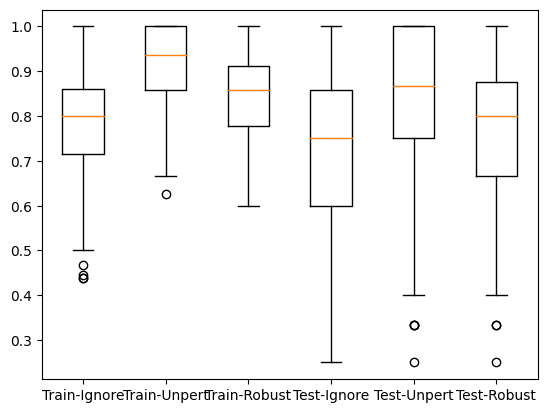

In [13]:
plt.boxplot([accs_train_ignore, accs_train_unpert, accs_train_robust, accs_test_ignore, accs_test_unpert, accs_test_robust])
plt.xticks(np.arange(1,7), ["Train-Ignore", "Train-Unpert", "Train-Robust", "Test-Ignore", "Test-Unpert", "Test-Robust"])

In [14]:
np.mean(accs_train_ignore), np.mean(accs_train_unpert), np.mean(accs_test_ignore), np.mean(accs_test_unpert)

(0.7768070119175505,
 0.9207899998477165,
 0.7364192988644255,
 0.8501182138285739)

In [15]:
errs_S.mean(), np.median(errs_S)

(7.361113825191507, 7.202930805582121)

# Different training and test graphs

In [16]:
accs_train_unpert = np.zeros(n_graphs)
accs_test_unpert = np.zeros(n_graphs)

accs_train_ignore = np.zeros(n_graphs)
accs_test_ignore = np.zeros(n_graphs)

accs_train_robust = np.zeros(n_graphs)
accs_test_robust = np.zeros(n_graphs)

out_dim = max([(node_labels[i].max()+1).item() for i in range(n_graphs)])

gcn_ignore = arch.GCNCoefs(torch.zeros((10,10)).to(device), in_dim, hid_dim, out_dim, n_layers, K).to(device)
model_gnn_ignore = model.Model(gcn_ignore, n_epochs*n_iters, lr, wd, eval_freq)

# GNN Unpert
gcn_unpert = arch.GCNCoefs(torch.zeros((10,10)).to(device), in_dim, hid_dim, out_dim, n_layers, K).to(device)
model_gnn_unpert = model.Model(gcn_unpert, n_epochs*n_iters, lr, wd, eval_freq)

# GNN Ignore
gcn_ignore = arch.GCNCoefs(torch.zeros((10,10)).to(device), in_dim, hid_dim, out_dim, n_layers, K).to(device)
model_gnn_ignore = model.Model(gcn_ignore, n_epochs*n_iters, lr, wd, eval_freq)

# GNN Robust
gcn_robust = arch.GCNCoefs(torch.zeros((10,10)).to(device), in_dim, hid_dim, out_dim, n_layers, K).to(device)
model_gnn_robust = model.Model(gcn_robust, n_epochs*n_iters, lr, wd, eval_freq)

for i in range(n_graphs):

    N = adjs[i].shape[0]
    N_train = int(tts*N)

    train_mask = torch.ones(N, dtype=torch.bool)
    test_mask = []

    # GNN Unpert
    model_gnn_unpert.model.update_Spow(adjs[i])

    acc_train, acc_val, acc_test, losses = \
        model_gnn_unpert.test_clas(adjs[i], node_attrs[i], node_labels[i], gamma, train_mask, [], test_mask)

    accs_train_unpert[i] = acc_train.max()

    Sn = torch.Tensor(pert_S(adjs[i].cpu().numpy(), type="prob", eps=0.25)).to(device)

    # GNN Ignore
    model_gnn_ignore.model.update_Spow(Sn)

    acc_train, acc_val, acc_test, losses = \
        model_gnn_ignore.test_clas(Sn, node_attrs[i], node_labels[i], gamma, train_mask, [], test_mask)

    accs_train_ignore[i] = acc_train.max()

    model_gnn_robust.model.update_Spow(Sn)

    acc_train, acc_test = \
        model_gnn_robust.test_iterative(Sn, node_attrs[i], node_labels[i], lambd, gamma, n_iters, train_mask, [], test_mask)

    accs_train_ignore[i] = acc_train.max()

for i in range(n_graphs, 2*n_graphs):
    model_gnn_unpert.model.update_Spow(adjs[i])
    accs_test_unpert[i-n_graphs] = model_gnn_unpert.eval_acc(node_attrs[i], node_labels[i])

    Sn = torch.Tensor(pert_S(adjs[i].cpu().numpy(), type="prob", eps=0.25)).to(device)
    model_gnn_ignore.model.update_Spow(Sn)
    accs_test_ignore[i-n_graphs] = model_gnn_ignore.eval_acc(node_attrs[i], node_labels[i])

Epoch 1/400 - Loss: 131.4319610595703 - Train Acc: 0.05882352963089943 - Test Acc: nan
Epoch 100/400 - Loss: 0.25940123200416565 - Train Acc: 0.9411764740943909 - Test Acc: nan
Epoch 200/400 - Loss: 0.22899049520492554 - Train Acc: 1.0 - Test Acc: nan
Epoch 300/400 - Loss: 0.22174853086471558 - Train Acc: 0.8823529481887817 - Test Acc: nan
Epoch 400/400 - Loss: 0.21691840887069702 - Train Acc: 0.8823529481887817 - Test Acc: nan
Epoch 1/400 - Loss: 872.9156494140625 - Train Acc: 0.0 - Test Acc: nan
Epoch 100/400 - Loss: 0.7538403868675232 - Train Acc: 0.8235294222831726 - Test Acc: nan
Epoch 200/400 - Loss: 0.6938696503639221 - Train Acc: 0.8235294222831726 - Test Acc: nan
Epoch 300/400 - Loss: 0.6938693523406982 - Train Acc: 0.8235294222831726 - Test Acc: nan
Epoch 400/400 - Loss: 0.6938695311546326 - Train Acc: 0.8235294222831726 - Test Acc: nan


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

([<matplotlib.axis.XTick at 0x7f2088040640>,
 [Text(1, 0, 'Train-Ignore'),
  Text(2, 0, 'Train-Unpert'),
  Text(3, 0, 'Test-Ignore'),
  Text(4, 0, 'Test-Unpert')])

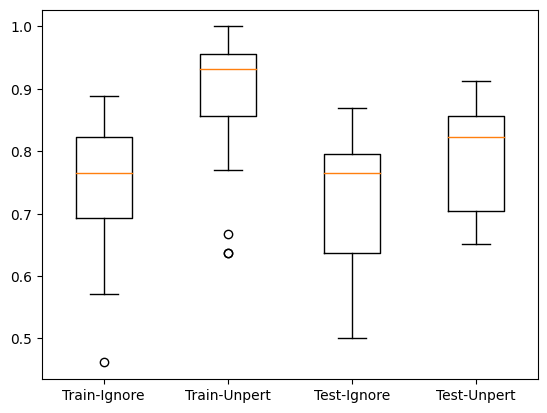

In [ ]:
plt.boxplot([accs_train_ignore, accs_train_unpert, accs_test_ignore, accs_test_unpert])
plt.xticks(np.arange(1,5), ["Train-Ignore", "Train-Unpert", "Test-Ignore", "Test-Unpert"])

In [ ]:
np.mean(accs_train_ignore), np.mean(accs_train_unpert), np.mean(accs_test_ignore), np.mean(accs_test_unpert)

(0.7444376508394878,
 0.8942698657512664,
 0.7187591552734375,
 0.7962747116883596)